# Class Imbalance Problems - Lab

## Introduction


Now that you've gone over some techniques for tuning classification models on imbalanced datasets, it's time to practice those techniques. In this lab, you'll investigate credit card fraud and attempt to tune a model to flag suspicious activity.

## Objectives

You will be able to:

- Use sampling techniques to address a class imbalance problem within a dataset 
- Create a visualization of ROC curves and use it to assess a model

## Predicting credit card fraud


The following cell loads all the functions you will be using in this lab. All you need to do is run it: 

In [3]:
pip install pandas

     |████████████████████████████████| 10.7 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 16.1 MB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 22.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c conda-forge imbalanced-learn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/Joe/opt/anaconda3/envs/learn-env2

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.1                   |         openblas           1 KB  conda-forge
    ca-certificates-2020.12.5  |       h033912b_0         138 KB  conda-forge
    certifi-2020.12.5          |   py39h6e9494a_1         143 KB  conda-forge
    imbalanced-learn-0.8.0     |     pyhd8ed1ab_0         109 KB  conda-forge
    joblib-1.0.1               |     pyhd8ed1ab_0         206 KB  conda-forge
    libgfortran-3.0.1          |                0         495 KB  conda-forge
    libopenblas-0.3.10         |       h0794

In [2]:
pip install matplotlib

     |████████████████████████████████| 8.5 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 461 kB/s eta 0:00:01
     |████████████████████████████████| 67 kB 7.3 MB/s  eta 0:00:01
     |████████████████████████████████| 2.2 MB 24.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sklearn

In [3]:
sklearn_version = sklearn.__version__

In [4]:
sklearn_version

'0.24.1'

Use Pandas to load the compressed CSV file, `'creditcard.csv.gz'`. 

> Note: You need to pass an additional argument (`compression='gzip'`) to read_csv() in order to load compressed CSV files. 

In [5]:
# Load a compressed csv file
df = pd.read_csv('creditcard.csv.gz', compression='gzip')

# Print the first five rows of data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Preview the class imbalance

Did you notice that the dataset has 31 columns? The first is a time field followed by columns V1 - V28, created by way of manual feature engineering done on the backend that we have little information about. Finally, there's the amount of the purchase and a binary `'Class'` flag. This last column, `'Class'`, is the indication of whether or not the purchase was fraudulent, and it is what you should be attempting to predict.

Take a look at how imbalanced this dataset is: 

In [6]:
# Count the number of fraudulent/infraudulent purchases
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Define the predictor and target variables

Define `X` and `y` and perform a standard train-test split. Assign 25% to the test set and `random_state` to 0. 

In [7]:

# Your code here
y = df['Class']
X = df.drop(['Class'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=0)

Find the class imbalance in the training and test sets: 

In [8]:
X_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
194763,130747.0,2.047163,0.107987,-1.806515,0.072733,0.248371,-1.744837,0.712448,-0.488842,-0.102709,...,-0.261380,0.241017,0.822618,0.023000,0.549868,0.322173,0.191755,-0.085025,-0.084292,0.77
135660,81344.0,1.282404,0.459864,-0.372286,0.826375,0.463568,-0.466407,0.460867,-0.186469,-0.549700,...,-0.096751,0.013986,0.083896,-0.247504,-0.325527,0.927293,-0.272555,-0.010168,-0.005332,1.79
259186,159004.0,-0.414863,0.012026,1.356386,1.107374,0.813456,-0.156497,-0.372675,0.031095,-0.100143,...,0.564341,-0.052272,-0.088160,0.062521,-0.680805,-0.641474,-0.159995,0.237628,0.204343,5.95
87387,61662.0,-1.432948,1.478076,0.576724,0.207540,-0.670662,-0.464572,0.221023,-0.099811,1.561896,...,0.266179,-0.055014,0.364330,0.154670,0.635611,-0.366314,0.163690,-0.750285,-0.275117,9.20
267282,162703.0,2.051016,-0.016765,-2.284865,0.302168,0.786895,-0.998558,0.768990,-0.464383,0.362863,...,-0.139341,0.133331,0.491780,-0.119020,0.527179,0.607105,-0.090453,-0.065787,-0.062680,47.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211543,138459.0,-1.321976,1.138686,-0.940861,0.154160,0.109802,-0.538822,0.490058,0.513762,-0.493834,...,-0.436962,-0.012778,-0.237503,0.008713,-0.767844,-0.397162,0.316379,-0.463125,-0.010589,49.89
86293,61167.0,-0.627810,0.918729,1.478453,0.213171,0.933695,1.261486,0.504752,0.404286,-0.939740,...,0.088281,-0.051356,-0.004245,0.090535,-0.964599,-0.522294,0.296733,0.145939,0.110400,24.99
122579,76616.0,1.512602,-0.949435,-0.219062,-1.638850,-0.856348,-0.465996,-0.669193,-0.135566,-2.284345,...,-0.279028,-0.558803,-1.377240,0.080444,-0.579511,0.297851,-0.495367,-0.001415,0.003665,34.90
152315,97253.0,1.798863,-1.699791,-0.142182,-0.619533,-1.570248,0.083268,-1.501980,0.176287,1.755507,...,0.146098,0.181914,0.351358,0.115638,-0.566188,-0.596200,-0.295152,-0.033616,-0.032471,171.31


In [14]:
# Training set
print(y_train.value_counts())
print('\n')
# Test set
print(y_test.value_counts())

0    213233
1       372
Name: Class, dtype: int64


0    71082
1      120
Name: Class, dtype: int64


## Create an initial model

As a baseline, train a vanilla logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

AUC: 0.8841412031175263


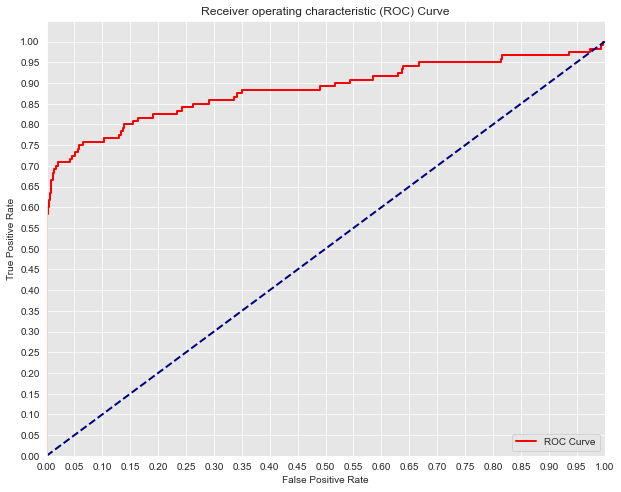

In [22]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train,y_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test,y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr,tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr,tpr, color='red', lw=lw, label='ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Use scikit-learn's `plot_confusion_matrix` function to plot the confusion matrix of the test set: 

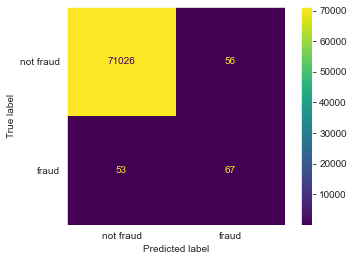

In [25]:
# Plot confusion matrix of the test set 
plot_confusion_matrix(logreg, X_test, y_test,
                      display_labels=["not fraud", "fraud"],
                      values_format=".5g")
plt.grid(False) # removes the annoying grid lines from plot
plt.show()

## Tune the model 

Try some of the various techniques proposed to tune your model. Compare your models using AUC and ROC curve.

LogisticRegression(C=0.001, fit_intercept=False, solver='liblinear')
AUC for 0.001: 0.8397641690817178
-------------------------------------------------------
LogisticRegression(C=0.01, fit_intercept=False, solver='liblinear')
AUC for 0.01: 0.881781018166812
-------------------------------------------------------
LogisticRegression(C=0.1, fit_intercept=False, solver='liblinear')
AUC for 0.1: 0.8839374478302054
-------------------------------------------------------
LogisticRegression(C=1, fit_intercept=False, solver='liblinear')
AUC for 1: 0.8841412031175263
-------------------------------------------------------
LogisticRegression(C=10, fit_intercept=False, solver='liblinear')
AUC for 10: 0.8841610159158905
-------------------------------------------------------
LogisticRegression(C=100, fit_intercept=False, solver='liblinear')
AUC for 100: 0.8841632433902629
-------------------------------------------------------


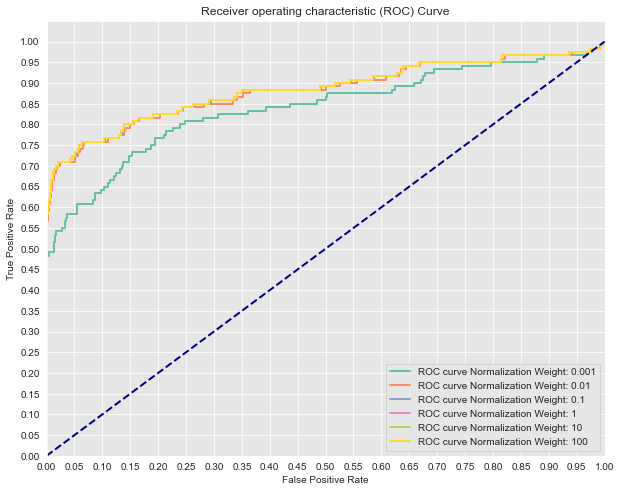

In [29]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
names = [0.001, 0.01, 0.1, 1, 10, 100]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### SMOTE

Use the `SMOTE` class from the `imblearn` package in order to improve the model's performance on the minority class. 

In [30]:
# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

# Note, if you get an Attribute Error: 'SMOTE' object has no attribute
# '_validate_data', then downgrade your version of imblearn to 0.6.2
# or upgrade your version of sklearn to 0.23

0    213233
1       372
Name: Class, dtype: int64


0    213233
1    213233
Name: Class, dtype: int64


Similar to what you did above, build models with this resampled training data: 

LogisticRegression(C=0.005, fit_intercept=False, solver='liblinear')
AUC for 0.005: 0.9632975530607841
-------------------------------------------------------
LogisticRegression(C=0.1, fit_intercept=False, solver='liblinear')
AUC for 0.1: 0.9632785609108729
-------------------------------------------------------
LogisticRegression(C=0.2, fit_intercept=False, solver='liblinear')
AUC for 0.2: 0.9632780919688997
-------------------------------------------------------
LogisticRegression(C=0.5, fit_intercept=False, solver='liblinear')
AUC for 0.5: 0.9627728069928627
-------------------------------------------------------
LogisticRegression(C=0.8, fit_intercept=False, solver='liblinear')
AUC for 0.8: 0.9632775057914333
-------------------------------------------------------
LogisticRegression(C=1, fit_intercept=False, solver='liblinear')
AUC for 1: 0.9627729242283559
-------------------------------------------------------
LogisticRegression(C=1.25, fit_intercept=False, solver='liblinear')
AU

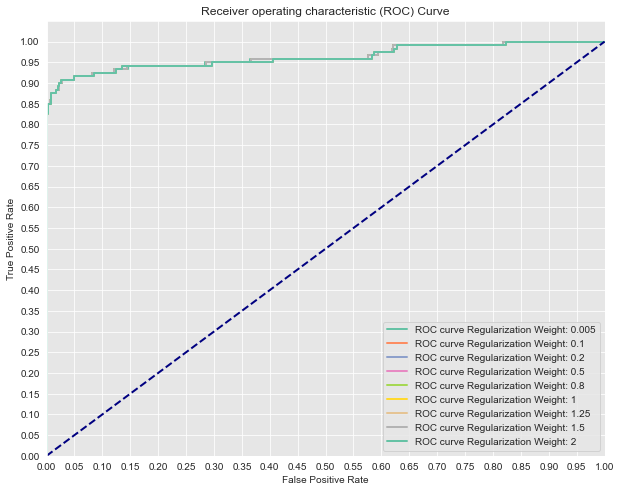

In [31]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Something wrong here? 
Describe what is misleading about the AUC score and ROC curves produced by this code:

0    284315
1       492
Name: Class, dtype: int64
---------------------------------
0    284315
1    284315
Name: Class, dtype: int64
----------------------------------------------
AUC for 0.005: 0.9887666841544764
----------------------------------------------
AUC for 0.1: 0.9887694686980361
----------------------------------------------
AUC for 0.2: 0.9887694605827188
----------------------------------------------
AUC for 0.3: 0.9887695656859765
----------------------------------------------
AUC for 0.5: 0.9887695597479392
----------------------------------------------
AUC for 0.6: 0.9887695498512108
----------------------------------------------
AUC for 0.7: 0.9887695633107614
----------------------------------------------
AUC for 0.8: 0.9887694772092227


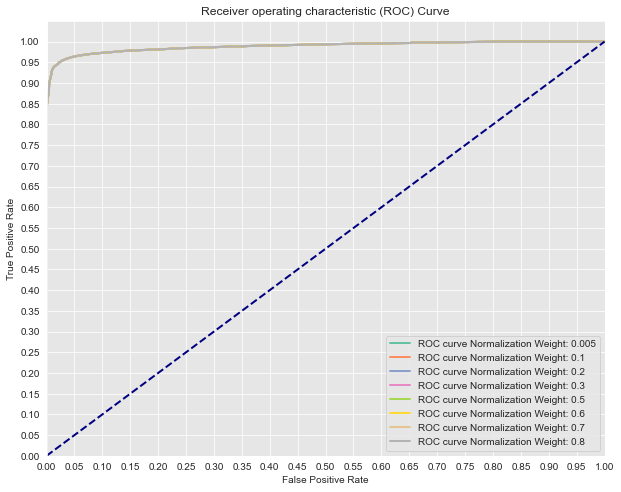

In [34]:
# Previous original class distribution
print(y.value_counts()) 
X_resampled, y_resampled = SMOTE().fit_resample(X, y) 
# Preview synthetic sample class distribution
print('---------------------------------')
print(pd.Series(y_resampled).value_counts()) 

# Split resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
names = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('----------------------------------------------')
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Your response here

## Summary

In this lab, you got some hands-on practice tuning logistic regression models. In the upcoming labs and lessons, you will continue to dig into the underlying mathematics of logistic regression, taking on a statistical point of view and providing you with a deeper understanding of how the algorithm works. This should give you further insight as to how to tune and apply these models going forward.